# Extrinsic Parameter Calibration for Line Scanning Cameras on Ground Vehicles with Navigation Systems Using a Calibration Pattern
# Example jupyter notebook

This example notebook demonstrates the use of the line scanning camera extrinsic calibration code as detailed in the following bibtex citation. It replicates the results using 16 observations from the Ladybird platform (see Table 3).

`@Article{s17112491,
AUTHOR = {Wendel, Alexander and Underwood, James},
TITLE = {Extrinsic Parameter Calibration for Line Scanning Cameras on Ground Vehicles with Navigation Systems Using a Calibration Pattern},
JOURNAL = {Sensors},
VOLUME = {17},
YEAR = {2017},
NUMBER = {11},
ARTICLE NUMBER = {2491},
URL = {http://www.mdpi.com/1424-8220/17/11/2491},
ISSN = {1424-8220},
DOI = {10.3390/s17112491}
}`

In [1]:
import numpy as np
import csv
import corner
from ls_calibrate_reproj_likelihood import LSCalibrateReprojLikelihood

## Load data (observations, extrinsics and intrinsics)

Load nav system covariances from csv file. These are all covariances provided by the navigation system during acquisition. Using the time stamps, they will be matched to each observation of a calibration pattern point. The first field in the csv file is a time stamp, followed by 144 fields corresponding to the full 12x12 covariance matrix provided by the navigation system. From this we only need the upper left 6x6 matrix for x, y, z, roll, pitch and yaw.

In [2]:
nav_cov_ts = list()
nav_covs = list()

with open('data/nav_covs.csv', 'r') as f:
    csv_reader = csv.reader(f)

    for row in csv_reader:
        nav_cov_ts.append(np.int64(row[0]))
        cov = np.array(row[1:]).astype(float)
        cov = np.reshape(cov, (int(len(cov)**0.5), int(len(cov)**0.5)))
        nav_covs.append(cov[:6, :6])

Set extrinsics, intrinsics and other covariances, and load calibration object.

In [3]:
# set initial hand measured extrinsics (in axis angle format) (as per Table 3)
init_ext = np.array([0.200000, 0.000000, -0.800000, -0.761980, 0.761980, -1.433077])

# uv and intrinsic covariances
# as per Section 3.4
uv_cov = np.array([[0.5, 0.0],
                   [0.0, 0.5]])**2
int_cov = np.array([[2.0, 0.0],
                    [0.0, 0.0001]])**2
dist_cov = np.array([[0.0, 0.0],
                     [0.0, 0.0]])

# set intrinsics
# as per Section 3.1 and Table 1
args = {'sensor_size': 0.0048,
        'focal_length': 0.0082,
        'resolution': 648,
        'principal_point': 323,
        'k1': 0.,
        'k2': 0.,
        'extrinsics': init_ext,
        'v0': 0.0,
        'ext_rep': 'aa',
        'nav_covs': nav_covs,
        'nav_cov_ts': nav_cov_ts,
        'uv_cov': uv_cov,
        'int_cov': int_cov,
        'dist_cov': dist_cov,
        'ext_cov': None}

line_scan_cal = LSCalibrateReprojLikelihood(**args)

Load observations, which are saved in the following csv format (one csv per full observation of the calibration pattern):

`time_stamp, point_id, pixel_x, nav_x, nav_y, nav_z, nav_roll, nav_pitch, nav_yaw`

In [4]:
# list of observations used for Ladybird with 16 observations (see Table 3 in paper)
obs_data_list = ['data/labelled_points/20160616T012733-20160616T012745-split_target_points.csv',
                 'data/labelled_points/20160616T013058-20160616T013108-split_target_points.csv',
                 'data/labelled_points/20160616T013619-20160616T013638-split_target_points.csv',
                 'data/labelled_points/20160616T014000-20160616T014024-split_target_points.csv',
                 'data/labelled_points/20160616T014345-20160616T014402-split_target_points.csv',
                 'data/labelled_points/20160616T014639-20160616T014659-split_target_points.csv',
                 'data/labelled_points/20160616T021441-20160616T021447-split_target_points.csv',
                 'data/labelled_points/20160616T021635-20160616T021641-split_target_points.csv',
                 'data/labelled_points/20160616T022831-20160616T022836-split_target_points.csv',
                 'data/labelled_points/20160616T022957-20160616T023003-split_target_points.csv',
                 'data/labelled_points/20160616T023142-20160616T023148-split_target_points.csv',
                 'data/labelled_points/20160616T023244-20160616T023250-split_target_points.csv',
                 'data/labelled_points/20160616T023422-20160616T023428-split_target_points.csv',
                 'data/labelled_points/20160616T023535-20160616T023541-split_target_points.csv',
                 'data/labelled_points/20160616T024320-20160616T024326-split_target_points.csv',
                 'data/labelled_points/20160616T024601-20160616T024606-split_target_points.csv']

# load observations
for fn in obs_data_list:
    with open(fn, 'r') as f:
        csv_reader = csv.reader(f, delimiter=',')
        for row in csv_reader:
            line_scan_cal.add_data_point(ts=np.int64(row[0]), 
                                         index=int(row[1]), 
                                         x=np.float64(row[2]),
                                         world_coords=np.array(row[3:]).astype(np.float64))

## Perform optimisation

In [5]:
# lmfit parameters for powell minimiser (xtol and ftol as per Section 3.4)
minimizer_kws = {"options": {"disp": False, 
                             "return_all": False, 
                             "maxiter": 100000, 
                             "direc": None,
                             "maxfev": 100000,
                             "xtol": 1.000000e-05,
                             "ftol": 1.000000e-08}}

res = line_scan_cal.optimise(intrinsics=None, method="powell",
                             minimizer_kws=minimizer_kws)


Assigning covariance matrices to each sample...
Final residual: 51.574661


In [6]:
ext = np.copy(line_scan_cal.cam_params['extrinsics'])

print ("Extrinsics result: %.3f, %.3f, %.3f, %.3f, %.3f, %.3f" % tuple(ext))

Extrinsics result: 0.189, -0.142, -0.794, -0.822, 0.738, -1.429


This should match the result given for 16 observations in Table 3.

## Estimate uncertainty using MCMC

In [7]:
# starting covariance, used to randomly assign initial walker positions
mcmc_starting_cov = np.diag([0.1,0.1,0.1,0.01,0.01,0.01])**2

# run uncertainty estimator, number of walkers and number of samples are as per Section 3.4
chain, ln_prob, acceptance_fraction = line_scan_cal.mcmc_sampling(starting_cov=mcmc_starting_cov, 
                                                                  num_walkers=250, 
                                                                  num_samples_per_walker=100, 
                                                                  log_file=None,
                                                                  burnin_samples=100,
                                                                  mcmc_scale=2.5)


Assigning covariance matrices to each sample...
Running MCMC burn in with 250 walkers and 100 samples (scale parameter = 2.50)...
Running main MCMC sampler with 250 walkers and 100 samples each (scale parameter = 2.50)...


In [8]:
flat_chain = np.reshape(chain, (-1, 6))
print ("Extrinsics uncertainties : %.3f, %.3f, %.3f, %.3f, %.3f, %.3f" % tuple(np.std(flat_chain, ddof=1, axis=0)))

Extrinsics uncertainties : 0.032, 0.054, 0.059, 0.016, 0.018, 0.009


This should match the uncertainties given in Table 3 for 16 observations.

### Corner plot of MCMC samples

This replicates the corner plot from Fig. 10 (a).

/home/awendel/tensorflow_virtual_env/local/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/awendel/tensorflow_virtual_env/local/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


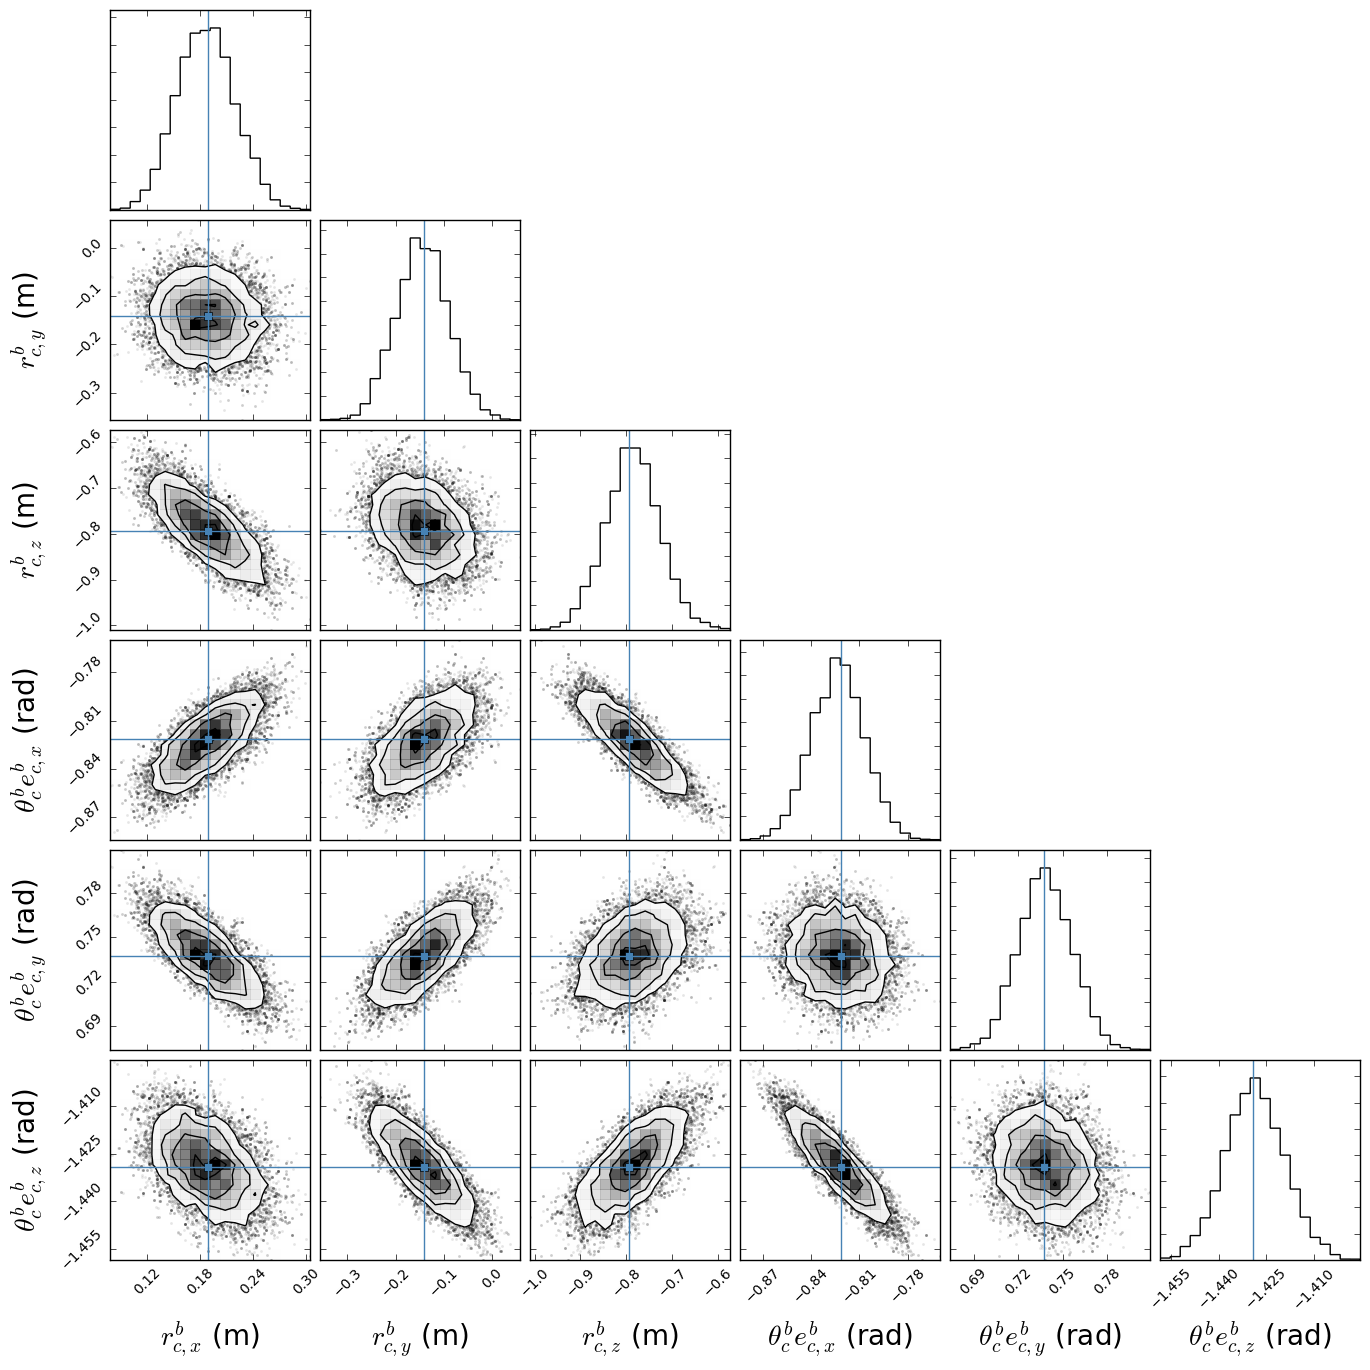

In [9]:
labels = [r'$r_{c,x}^b$ (m)', r'$r_{c,y}^b$ (m)', r'$r_{c,z}^b$ (m)', 
          r'$\theta_c^b e_{c,x}^b$ (rad)', r'$\theta_c^b e_{c,y}^b$ (rad)', 
          r'$\theta_c^b e_{c,z}^b$ (rad)']

label_kwargs = {'fontdict': {'family': 'sans-serif',
                             'color':  'k',
                             'weight': 'normal',
                             'size': 20}
               }

corner.corner(flat_chain, labels=labels,
              truths=ext,
              label_kwargs=label_kwargs)